## ПЗ 6


### **1) Импорт пакетов**


In [1]:

import tensorflow as tf
import numpy as np
import glob
import os
from PIL import Image , ImageOps



### **2) Загрузка набора данных Cityscape**

Загрузим подмножество исходного набора данных из Kaggle.com. Это [Cityscapes Image Pairs](https://www.kaggle.com/dansbecker/cityscapes-image-pairs) от [DanB](https://www.kaggle.com/dansbecker). 


### **3) Обработка изображений.**

Разделим составное изображение на две части: одну, которая содержит маску, и вторую, которая является фактическим изображением.

- Класс "дорога" в маске имеет цвет значения RGB `( 128 , 63 , 127 )`. Преобразуем изображение в двоичную форму.
- Пикселям, имеющим значение RGB `( 128 , 63 , 127 )` будет присвоено новое значение 1. Остальные все пиксели будут иметь новое значение 0.
- Следовательно, форма изображения изменяется с `( 128 , 128 , 3 )` на `( 128 , 128 , 1 )`.


In [2]:

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

x = list()
y = list()

num_images = 400 

image_dir = 'cityscape_images/images'
image_filenames = os.listdir( image_dir )
for filename in image_filenames[ 0 : 100 ]:
    image = Image \
        .open(os.path.join( image_dir, filename))
    x.append( np.asarray( ImageOps.crop( image , ( 0 , 0 , 256 , 0 ) ).resize( ( 128, 128 )) ) )
    y.append(np.asarray( ImageOps.crop(image, (256, 0, 0, 0)).resize( ( 128 , 128 ) ) ))

x = np.array( x ) / 255
y = np.array( y )

train_features, test_features, train_labels, test_labels = train_test_split(np.array(x), np.array(y),
                                                                                    test_size=0.4)

def binarize( pixel ):
    if np.array_equal( pixel , [ 128 , 63 , 127 ]):
        return np.array( [ 1 ] )
    else :
        return np.array( [ 0 ] )

train_labels = np.apply_along_axis( binarize , axis=3 , arr=train_labels ) 
test_labels = np.apply_along_axis( binarize , axis=3 , arr=test_labels ) 

batch_size = 5 

train_dataset = tf.data.Dataset.from_tensor_slices( ( train_features , train_labels ) )
train_dataset = train_dataset.shuffle( 1024 ).batch( batch_size )
test_dataset = tf.data.Dataset.from_tensor_slices( ( test_features , test_labels ) )
test_dataset = test_dataset.shuffle( 1024 ).batch( batch_size )



### **4) Определение операций**

Определим методы для четырех операций:

1. `conv2d_down`: Обычная свертка с активацией Leaky ReLU.
2. `maxpool_down`: Операция Max Pooling с padding=valid .
3. `conv2d_up`: Транспонированная свертка для повышения разрешения изображения.
4. `maxpool_up`: Повышение дискретизации вводного сигнала.


In [3]:

relu_alpha = 0.2 

dropout_rate = 0.5

padding = 'SAME'

def conv2d_down( inputs , filters , stride_size ):
    #print( 'conv2d down' )
    out = tf.nn.conv2d( inputs , filters , strides=stride_size , padding=padding ) 
    return tf.nn.leaky_relu( out , alpha=0.2 ) 

def maxpool_down( inputs , pool_size , stride_size ):
    #print( 'maxpool down' )
    return tf.nn.max_pool( inputs , ksize=pool_size , padding='VALID' , strides=stride_size )

def conv2d_up( inputs , filters , stride_size , output_shape ):
    #print( 'conv2d up' )
    out = tf.nn.conv2d_transpose( inputs , filters , output_shape=output_shape , strides=stride_size , padding=padding ) 
    return tf.nn.leaky_relu( out , alpha=0.2 ) 

def maxpool_up( inputs , size ):
    #print( 'maxpool up' )
    in_dimen = tf.shape( inputs )[ 1 ]
    out_dimen = tf.cast( tf.round( in_dimen * size ) , dtype=tf.int32 ) 
    return tf.image.resize( inputs , [ out_dimen , out_dimen ] , method='nearest' ) 



### **5) Инициализация весов**


In [4]:

initializer = tf.initializers.glorot_uniform()
def get_weight( shape , name ):
    return tf.Variable( initializer( shape ) , name=name , trainable=True )

shapes = [
    [ 3 , 3 , 3 , 16 ] , 
    [ 3 , 3 , 16 , 16 ] , 

    [ 3 , 3 , 16 , 32 ] , 
    [ 3 , 3 , 32 , 32 ] ,

    [ 3 , 3 , 32 , 64 ] , 
    [ 3 , 3 , 64 , 64 ] ,

    [ 3 , 3 , 64 , 128 ] , 
    [ 3 , 3 , 128 , 128 ] ,

    [ 3 , 3 , 128 , 256 ] , 
    [ 3 , 3 , 256 , 256 ] ,

    [ 3 , 3 , 128 , 384 ],
    [ 3 , 3 , 128 , 128 ],

    [ 3 , 3 , 64 , 192 ],
    [ 3 , 3 , 64 , 64 ],

    [ 3 , 3 , 32 , 96 ],
    [ 3 , 3 , 32 , 32 ],

    [ 3 , 3 , 16 , 48 ],
    [ 3 , 3 , 16 , 16 ],

    [ 1 , 1 , 16 , 1 ],
]

weights = []
for i in range( len( shapes ) ):
    weights.append( get_weight( shapes[ i ] , 'weight{}'.format( i ) ) )



### **6) Сборка модели**


In [5]:

def model( x ) :
    batch_size = tf.shape( x )[0]
    x = tf.cast( x , dtype=tf.float32 )
    c1 = conv2d_down( x , weights[ 0 ] , stride_size=1 ) 
    c1 = conv2d_down( c1 , weights[ 1 ] , stride_size=1 ) 
    p1 = maxpool_down( c1 , pool_size=2 , stride_size=2 )
    
    c2 = conv2d_down( p1 , weights[ 2 ] , stride_size=1 )
    c2 = conv2d_down( c2 , weights[ 3 ] , stride_size=1 ) 
    p2 = maxpool_down( c2 , pool_size=2 , stride_size=2 )
    
    c3 = conv2d_down( p2 , weights[ 4 ] , stride_size=1 ) 
    c3 = conv2d_down( c3 , weights[ 5 ] , stride_size=1 ) 
    p3 = maxpool_down( c3 , pool_size=2 , stride_size=2 )
    
    c4 = conv2d_down( p3 , weights[ 6 ] , stride_size=1 )
    c4 = conv2d_down( c4 , weights[ 7 ] , stride_size=1 )
    p4 = maxpool_down( c4 , pool_size=2 , stride_size=2 )

    c5 = conv2d_down( p4 , weights[ 8 ] , stride_size=1 )
    c5 = conv2d_down( c5 , weights[ 9 ] , stride_size=1 ) 
        
    p5 = maxpool_up( c5 , 2 )
    concat_1 = tf.concat( [ p5 , c4 ] , axis=-1 ) 
    c6 = conv2d_up( concat_1 , weights[ 10 ] , stride_size=1 , output_shape=[ batch_size , 16 , 16 , 128 ] )
    c6 = conv2d_up( c6 , weights[ 11 ] , stride_size=1 , output_shape=[ batch_size , 16 , 16 , 128 ] )  

    p6 = maxpool_up( c6 , 2 )
    concat_2 = tf.concat( [ p6 , c3 ] , axis=-1 ) 
    c7 = conv2d_up( concat_2 , weights[ 12 ] , stride_size=1 , output_shape=[ batch_size , 32 , 32 , 64 ] )
    c7 = conv2d_up( c7 , weights[ 13 ] , stride_size=1 , output_shape=[ batch_size , 32 , 32 , 64 ] )  

    p7 = maxpool_up( c7 , 2 )
    concat_3 = tf.concat( [ p7 , c2 ] , axis=-1 ) 
    c8 = conv2d_up( concat_3 , weights[ 14 ] , stride_size=1 , output_shape=[ batch_size , 64 , 64 , 32 ] )
    c8 = conv2d_up( c8 , weights[ 15 ] , stride_size=1 , output_shape=[ batch_size , 64 , 64 , 32 ] )   

    p8 = maxpool_up( c8 , 2 )
    concat_4 = tf.concat( [ p8 , c1 ] , axis=-1 ) 
    c9 = conv2d_up( concat_4 , weights[ 16 ] , stride_size=1 , output_shape=[ batch_size , 128 , 128 , 16 ] )
    c9 = conv2d_up( c9 , weights[ 17 ] , stride_size=1 , output_shape=[ batch_size , 128 , 128 , 16 ] )   

    output = tf.nn.conv2d( c9 , weights[ 18 ] , strides=[ 1 , 1 , 1 , 1 ] , padding=padding ) 
    outputs = tf.nn.sigmoid( output ) 
    return outputs



### **7) Оптимизация и обучение**


In [6]:

def loss( pred , target ):
    return tf.losses.binary_crossentropy( target , pred )

learning_rate = "0.001" 
optimizer = tf.optimizers.Adam( learning_rate=float( learning_rate ) )

def train( model, inputs , outputs ):
    with tf.GradientTape() as tape:
        current_loss = loss( model( inputs ), outputs)
    grads = tape.gradient( current_loss , weights )
    optimizer.apply_gradients( zip( grads , weights ) )
    return tf.reduce_mean( current_loss )


In [7]:
  
import datetime

logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer( logdir + "/metrics")
file_writer.set_as_default()

num_epochs = 25 

for e in range( num_epochs ):
    print( 'Epoch {} out of {} {}'.format( e + 1 , num_epochs , '--' * 50 ) )
    for features in train_dataset:
        image , label = features
        summ_loss = train( model , image , label )
        tf.summary.scalar('loss', data=summ_loss, step=e )


Epoch 1 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 2 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 3 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 4 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 5 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 6 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 7 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 8 out of 25 ----------------------------------------------------------------------------------------------------
Epoch 9 out of 25 ------------------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


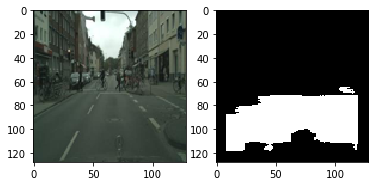

In [8]:

import matplotlib.pyplot as plt

input_image = test_features[0:1]
pred = model( input_image ).numpy()
image = np.zeros( ( 128 , 128 , 3 ) )
for x in range( 128 ):
    for y in range( 128 ):
        if pred[ 0 , x , y ] > 0.5:
            image[ x , y ] = [ 255 , 255 , 255 ]
        else:
            image[ x , y ] = [ 0, 0, 0]

def show_images(images: list):
    n = len(images)
    f = plt.figure()
    for i in range(n):
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i] , interpolation='none' )
    plt.show()

show_images( [ test_features[0] , image ] )
